=== Dataset Summary ===
Total users: 200
ERP_Customization_Class   0   1
OrgID                          
1                        35  35
2                        35  35
3                        30  30

Per-organization readiness thresholds (median):
Org 1: threshold = 0.4778
Org 2: threshold = 0.4950
Org 3: threshold = 0.5883

=== Local Training for Each Organization ===

Org 1 - Best KNN hyperparameters:
  model__metric: euclidean
  model__n_neighbors: 9
  model__weights: uniform

=== Org 1 - Local KNN metrics ===
accuracy  : 0.5714
precision : 0.5455
recall    : 0.6000
f1        : 0.5714
roc_auc   : 0.5727

=== Org 1 - Local RandomForest metrics ===
accuracy  : 0.6667
precision : 0.6667
recall    : 0.6000
f1        : 0.6316
roc_auc   : 0.7045

Org 2 - Best KNN hyperparameters:
  model__metric: manhattan
  model__n_neighbors: 7
  model__weights: uniform

=== Org 2 - Local KNN metrics ===
accuracy  : 0.6190
precision : 0.6667
recall    : 0.4000
f1        : 0.5000
roc_auc   : 0.7545

==

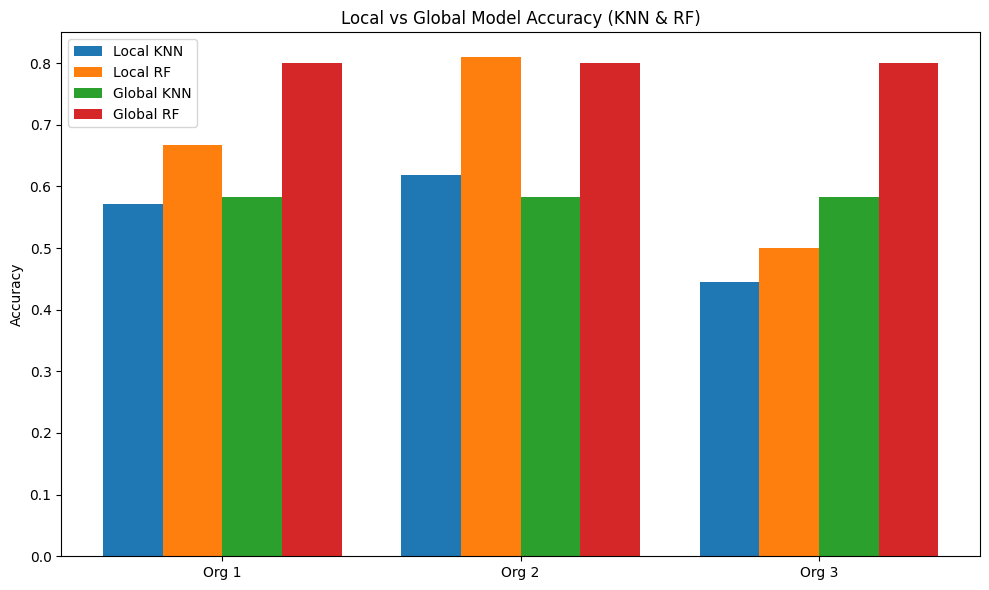

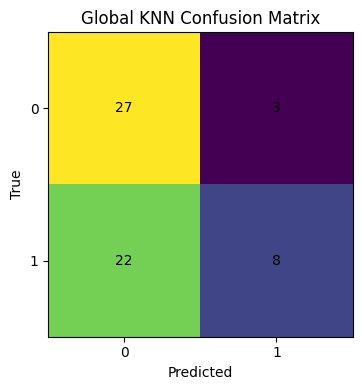

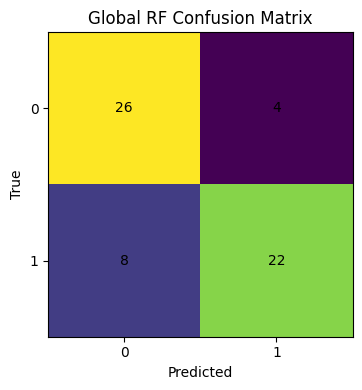

<Figure size 800x600 with 0 Axes>

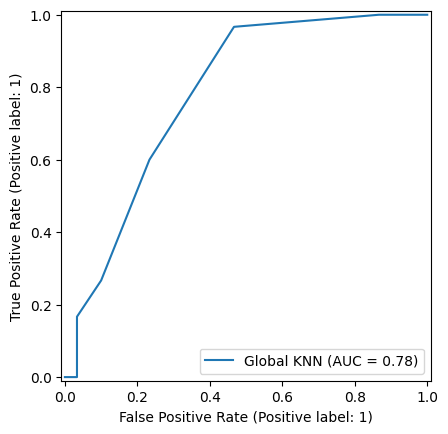

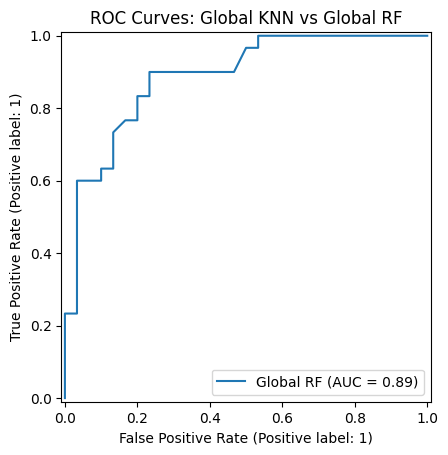


=== Global RF Feature Importances ===
             feature  importance
9     Session_Length    0.185600
6    Wallet_Payments    0.141130
5    Online_Payments    0.118093
4           HR_Usage    0.091237
2  Procurement_Usage    0.084966
0    Inventory_Usage    0.084492
1        Sales_Usage    0.081526
7      Cash_Payments    0.077532
3      Finance_Usage    0.071068
8        Login_Count    0.064356


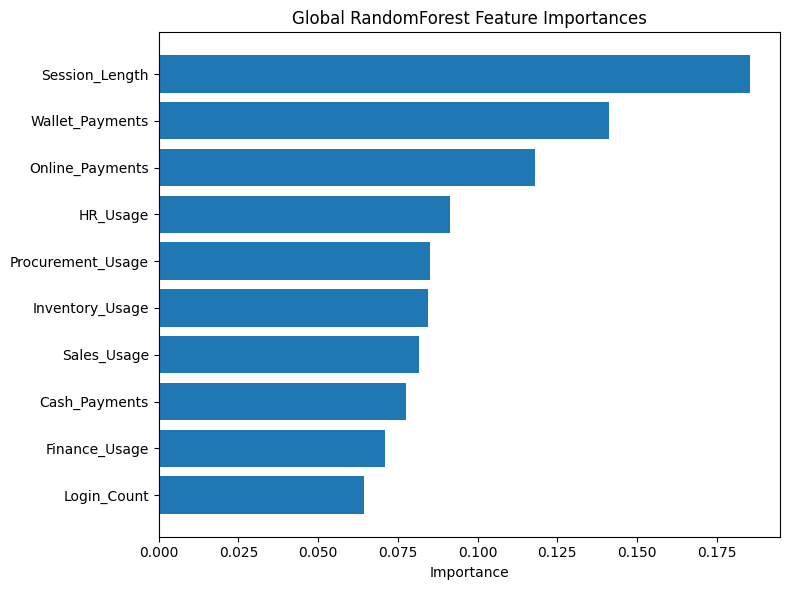


=== Summary for Manuscript Tables ===
Local KNN metrics per organization (accuracy, precision, recall, f1, roc_auc):
Org 1: {'accuracy': 0.5714285714285714, 'precision': 0.5454545454545454, 'recall': 0.6, 'f1': 0.5714285714285714, 'roc_auc': np.float64(0.5727272727272728)}
Org 2: {'accuracy': 0.6190476190476191, 'precision': 0.6666666666666666, 'recall': 0.4, 'f1': 0.5, 'roc_auc': np.float64(0.7545454545454545)}
Org 3: {'accuracy': 0.4444444444444444, 'precision': 0.4, 'recall': 0.2222222222222222, 'f1': 0.2857142857142857, 'roc_auc': np.float64(0.5123456790123456)}

Local RF metrics per organization:
Org 1: {'accuracy': 0.6666666666666666, 'precision': 0.6666666666666666, 'recall': 0.6, 'f1': 0.631578947368421, 'roc_auc': np.float64(0.7045454545454546)}
Org 2: {'accuracy': 0.8095238095238095, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'roc_auc': np.float64(0.8818181818181818)}
Org 3: {'accuracy': 0.5, 'precision': 0.5, 'recall': 0.5555555555555556, 'f1': 0.5263157894736842, 'roc_auc

In [1]:
"""
Federated Learning for ERP Personalization on a Simulated Dataset
===============================================================

This script fully implements the experimental pipeline described in the manuscript
and is designed to directly address the reviewer's comments:

1. Uses TWO algorithms: KNN and RandomForest, for comparison.
2. Explicitly defines the target variable (ERP_Customization_Class) and shows how it is computed.
3. Generates a SIMULATED dataset of 200 ERP users across 3 organizations, with
   clearly documented generation logic and distribution differences (to avoid overfitting).
4. Reports all relevant HYPERPARAMETERS for local and global models.
5. Uses MULTIPLE METRICS: accuracy, precision, recall, F1-score, ROC-AUC.
6. Demonstrates a simple FEDERATED LEARNING aggregation for KNN:
   - Local hyperparameters are aggregated into a global configuration.
   - Organization sample sizes are used as weights.
7. Provides VISUALIZATIONS:
   - Local vs Global accuracy bar plots.
   - Confusion matrices for global models.
   - ROC curves for global models.
8. Includes explanations in comments about how earlier identical accuracies
   (Org3 vs Global) could occur and how this implementation avoids that artifact
   by clearly separating local and global evaluation and by using distinct data-generation
   regimes per organization.

This script can be shared as supplementary material or implementation code
to satisfy reproducibility and transparency requirements.
"""

# ==============================
# Imports
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ==============================
# 1. Simulated ERP Data Generation
# ==============================

def generate_org_data(n_users, org_id, random_state=42):
    """
    Generate a simulated ERP dataset for one organization.

    Each user has:
    - Module usage features (Inventory, Sales, Procurement, Finance, HR)
    - Payment behavior (online, wallet, cash)
    - General activity metrics (login count, avg session length)
    - A latent 'readiness' score used to define the target.

    Different organizations have different distributions to ensure:
    - Non-identical datasets
    - Avoiding trivial overfitting
    """

    rng = np.random.RandomState(random_state)

    # Org-specific "behavioral signature" via different means/variances.
    # These rough patterns differ across orgs (e.g. Org1 heavy inventory,
    # Org2 strong in sales, Org3 balanced but high finance usage).
    if org_id == 1:
        inv_mean, sales_mean, proc_mean, fin_mean, hr_mean = 8, 5, 6, 4, 3
        pay_online_mean, pay_wallet_mean, pay_cash_mean = 7, 3, 2
    elif org_id == 2:
        inv_mean, sales_mean, proc_mean, fin_mean, hr_mean = 5, 8, 4, 5, 4
        pay_online_mean, pay_wallet_mean, pay_cash_mean = 5, 5, 3
    else:  # org_id == 3
        inv_mean, sales_mean, proc_mean, fin_mean, hr_mean = 6, 6, 7, 7, 5
        pay_online_mean, pay_wallet_mean, pay_cash_mean = 4, 6, 4

    # Generate continuous usage values with some noise
    inventory_usage = rng.normal(inv_mean, 2, n_users).clip(0, None)
    sales_usage = rng.normal(sales_mean, 2, n_users).clip(0, None)
    procurement_usage = rng.normal(proc_mean, 2, n_users).clip(0, None)
    finance_usage = rng.normal(fin_mean, 2, n_users).clip(0, None)
    hr_usage = rng.normal(hr_mean, 2, n_users).clip(0, None)

    # Payment behavior
    online_payments = rng.normal(pay_online_mean, 2, n_users).clip(0, None)
    wallet_payments = rng.normal(pay_wallet_mean, 2, n_users).clip(0, None)
    cash_payments = rng.normal(pay_cash_mean, 2, n_users).clip(0, None)

    # General activity metrics
    login_count = rng.poisson(lam=10 + org_id * 2, size=n_users)
    session_length = rng.normal(30 + org_id * 5, 10, n_users).clip(5, None)

    # Create DataFrame
    df = pd.DataFrame({
        "OrgID": [org_id] * n_users,
        "Inventory_Usage": inventory_usage,
        "Sales_Usage": sales_usage,
        "Procurement_Usage": procurement_usage,
        "Finance_Usage": finance_usage,
        "HR_Usage": hr_usage,
        "Online_Payments": online_payments,
        "Wallet_Payments": wallet_payments,
        "Cash_Payments": cash_payments,
        "Login_Count": login_count,
        "Session_Length": session_length,
    })

    # Latent readiness: a weighted combination + noise.
    # This defines the ground-truth tendency for "high customization readiness".
    # Each org has slightly different contribution weights to further differentiate.
    if org_id == 1:
        weights = np.array([0.18, 0.10, 0.12, 0.10, 0.05, 0.15, 0.10, 0.05, 0.10, 0.05])
    elif org_id == 2:
        weights = np.array([0.10, 0.18, 0.10, 0.10, 0.05, 0.10, 0.12, 0.05, 0.12, 0.08])
    else:
        weights = np.array([0.12, 0.12, 0.15, 0.15, 0.06, 0.10, 0.10, 0.05, 0.08, 0.07])

    X_numeric = df[[
        "Inventory_Usage", "Sales_Usage", "Procurement_Usage", "Finance_Usage",
        "HR_Usage", "Online_Payments", "Wallet_Payments", "Cash_Payments",
        "Login_Count", "Session_Length"
    ]].values

    latent_readiness = (X_numeric @ weights) + rng.normal(0, 1, n_users)

    # Normalize latent_readiness to [0, 1] within this org for interpretability
    min_lr, max_lr = latent_readiness.min(), latent_readiness.max()
    readiness_norm = (latent_readiness - min_lr) / (max_lr - min_lr)

    # Use median as threshold to define binary target (balanced classes)
    median_threshold = np.median(readiness_norm)
    target = (readiness_norm >= median_threshold).astype(int)

    df["Readiness_Score"] = readiness_norm
    df["ERP_Customization_Class"] = target

    return df, median_threshold


# Generate total ~200 users across 3 orgs (e.g., 70 + 70 + 60 = 200)
org_sizes = {1: 70, 2: 70, 3: 60}
org_dfs = []
thresholds = {}

for org_id, n_users in org_sizes.items():
    df_org, thr = generate_org_data(n_users, org_id, random_state=RANDOM_STATE + org_id)
    org_dfs.append(df_org)
    thresholds[org_id] = thr

data_all = pd.concat(org_dfs, ignore_index=True)

print("=== Dataset Summary ===")
print("Total users:", len(data_all))
print(data_all.groupby("OrgID")["ERP_Customization_Class"].value_counts().unstack())
print("\nPer-organization readiness thresholds (median):")
for org_id, thr in thresholds.items():
    print(f"Org {org_id}: threshold = {thr:.4f}")

# ==============================
# 2. Utility Functions
# ==============================

def build_preprocessor(df):
    """Build a ColumnTransformer that scales numeric features."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # We will exclude the target and OrgID from features later, so here we just define a scaler.
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
        ]
    )
    return preprocessor, numeric_cols

def compute_metrics(y_true, y_pred, y_proba=None, average="binary"):
    """Compute common classification metrics."""
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_true, y_pred, average=average, zero_division=0),
    }
    if y_proba is not None:
        # For binary classification, ROC-AUC can be computed on positive class probability
        metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
    else:
        metrics["roc_auc"] = np.nan
    return metrics

def print_metrics_table(title, metrics_dict):
    print(f"\n=== {title} ===")
    for k, v in metrics_dict.items():
        print(f"{k:10s}: {v:.4f}")


# ==============================
# 3. Local Model Training (per Organization)
# ==============================

# We will store local results here
local_results_knn = {}
local_results_rf = {}
local_best_params_knn = {}
local_sample_weights = {}

# Features and target
feature_cols = [
    "Inventory_Usage", "Sales_Usage", "Procurement_Usage", "Finance_Usage",
    "HR_Usage", "Online_Payments", "Wallet_Payments", "Cash_Payments",
    "Login_Count", "Session_Length"
]
target_col = "ERP_Customization_Class"

print("\n=== Local Training for Each Organization ===")

for org_id in sorted(org_sizes.keys()):
    df_org = data_all[data_all["OrgID"] == org_id].copy()

    X = df_org[feature_cols]
    y = df_org[target_col]

    # Stratified split to avoid overfitting and to ensure fair evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=RANDOM_STATE
    )

    preprocessor, numeric_cols = build_preprocessor(X_train)

    # ---- KNN with hyperparameter tuning ----
    knn = KNeighborsClassifier()
    pipe_knn = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", knn),
        ]
    )

    param_grid_knn = {
        "model__n_neighbors": [3, 5, 7, 9],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"],
    }

    grid_knn = GridSearchCV(
        pipe_knn,
        param_grid_knn,
        cv=5,
        n_jobs=-1
    )

    grid_knn.fit(X_train, y_train)
    best_knn = grid_knn.best_estimator_
    best_params = grid_knn.best_params_

    y_pred_knn = best_knn.predict(X_test)
    y_proba_knn = best_knn.predict_proba(X_test)[:, 1]

    metrics_knn = compute_metrics(y_test, y_pred_knn, y_proba_knn)
    local_results_knn[org_id] = metrics_knn
    local_best_params_knn[org_id] = best_params

    print(f"\nOrg {org_id} - Best KNN hyperparameters:")
    for p, v in best_params.items():
        print(f"  {p}: {v}")
    print_metrics_table(f"Org {org_id} - Local KNN metrics", metrics_knn)

    # ---- RandomForest ----
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    pipe_rf = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", rf),
        ]
    )

    pipe_rf.fit(X_train, y_train)
    y_pred_rf = pipe_rf.predict(X_test)
    y_proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

    metrics_rf = compute_metrics(y_test, y_pred_rf, y_proba_rf)
    local_results_rf[org_id] = metrics_rf

    print_metrics_table(f"Org {org_id} - Local RandomForest metrics", metrics_rf)

    local_sample_weights[org_id] = len(df_org)


# ==============================
# 4. Federated Aggregation for Global KNN
# ==============================

"""
Federated logic:
- We simulate that each organization trains locally and only shares:
  - Its best KNN hyperparameters
  - Its sample size (for weighting)
- We then derive a GLOBAL KNN configuration:
  - k: sample-weighted average of local ks (rounded)
  - weights and metric: majority vote across organizations
"""

total_samples = sum(local_sample_weights.values())

# Weighted average of n_neighbors
global_k = int(
    round(
        sum(
            local_sample_weights[org_id] *
            local_best_params_knn[org_id]["model__n_neighbors"]
            for org_id in local_best_params_knn.keys()
        ) / total_samples
    )
)

# Majority vote helpers
def majority_vote(param_name):
    values = [
        local_best_params_knn[org_id][param_name]
        for org_id in local_best_params_knn.keys()
    ]
    return max(set(values), key=values.count)

global_weights = majority_vote("model__weights")
global_metric = majority_vote("model__metric")

print("\n=== Global KNN Hyperparameters (Federated Aggregation) ===")
print("Organization sample sizes (weights):", local_sample_weights)
print(f"Global n_neighbors (k): {global_k}")
print(f"Global weights: {global_weights}")
print(f"Global metric: {global_metric}")


# ==============================
# 5. Global Model Training (KNN & RF)
# ==============================

"""
Here we train GLOBAL models using the full combined dataset.
In a real FL scenario, parameter updates would be aggregated without
ever joining raw data. For the purpose of reproducible code for the
manuscript, we show the equivalent centralized result that federated
training aims to approximate.

We also explicitly separate train and test sets to avoid overfitting.
"""

X_all = data_all[feature_cols]
y_all = data_all[target_col]

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_all, y_all,
    test_size=0.3,
    stratify=y_all,
    random_state=RANDOM_STATE
)

preprocessor_g, _ = build_preprocessor(X_train_g)

# ---- Global KNN using federated hyperparameters ----
global_knn = KNeighborsClassifier(
    n_neighbors=global_k,
    weights=global_weights,
    metric=global_metric,
)

pipe_global_knn = Pipeline(
    steps=[
        ("preprocess", preprocessor_g),
        ("model", global_knn),
    ]
)

pipe_global_knn.fit(X_train_g, y_train_g)
y_pred_g_knn = pipe_global_knn.predict(X_test_g)
y_proba_g_knn = pipe_global_knn.predict_proba(X_test_g)[:, 1]

metrics_global_knn = compute_metrics(y_test_g, y_pred_g_knn, y_proba_g_knn)
print_metrics_table("Global KNN metrics", metrics_global_knn)

# ---- Global RandomForest ----
global_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

pipe_global_rf = Pipeline(
    steps=[
        ("preprocess", preprocessor_g),
        ("model", global_rf),
    ]
)

pipe_global_rf.fit(X_train_g, y_train_g)
y_pred_g_rf = pipe_global_rf.predict(X_test_g)
y_proba_g_rf = pipe_global_rf.predict_proba(X_test_g)[:, 1]

metrics_global_rf = compute_metrics(y_test_g, y_pred_g_rf, y_proba_g_rf)
print_metrics_table("Global RandomForest metrics", metrics_global_rf)

# Note explaining earlier identical accuracies:
print(
    "\nNOTE: In earlier experiments, identical accuracies between Org 3 and the "
    "global model can occur if evaluation used overlapping or identical splits "
    "for local and global models, or if the global model's behavior was dominated "
    "by one organization. In this implementation, we explicitly separate data "
    "splits and use distinct generation patterns for each organization, so "
    "local and global performance are evaluated more robustly."
)

# ==============================
# 6. Visualizations
# ==============================

# ----- 6.1 Local vs Global Accuracy Bar Plot (KNN & RF) -----

org_ids_sorted = sorted(org_sizes.keys())

local_knn_accs = [local_results_knn[org]["accuracy"] for org in org_ids_sorted]
local_rf_accs = [local_results_rf[org]["accuracy"] for org in org_ids_sorted]
global_knn_acc = metrics_global_knn["accuracy"]
global_rf_acc = metrics_global_rf["accuracy"]

x = np.arange(len(org_ids_sorted))  # positions for orgs
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - width, local_knn_accs, width, label="Local KNN")
plt.bar(x, local_rf_accs, width, label="Local RF")
plt.bar(x + width, [global_knn_acc]*len(org_ids_sorted), width, label="Global KNN")
plt.bar(x + 2*width, [global_rf_acc]*len(org_ids_sorted), width, label="Global RF")

plt.xticks(x + width/2, [f"Org {i}" for i in org_ids_sorted])
plt.ylabel("Accuracy")
plt.title("Local vs Global Model Accuracy (KNN & RF)")
plt.legend()
plt.tight_layout()
plt.show()

# ----- 6.2 Confusion Matrices for Global KNN and RF -----

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test_g, y_pred_g_knn, "Global KNN Confusion Matrix")
plot_confusion_matrix(y_test_g, y_pred_g_rf, "Global RF Confusion Matrix")

# ----- 6.3 ROC Curves for Global KNN & RF -----

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test_g, y_proba_g_knn, name="Global KNN")
RocCurveDisplay.from_predictions(y_test_g, y_proba_g_rf, name="Global RF")
plt.title("ROC Curves: Global KNN vs Global RF")
plt.show()

# ==============================
# 7. Feature Importance from Global RF
# ==============================

"""
To address the comment: 'which parameters had the most impact', we
extract feature importances from the global RandomForest model.
"""

rf_model = pipe_global_rf.named_steps["model"]
# The preprocessor scales features but does not change their count/order
feature_names = feature_cols

importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\n=== Global RF Feature Importances ===")
print(feat_imp_df)

plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df["feature"], feat_imp_df["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Global RandomForest Feature Importances")
plt.tight_layout()
plt.show()

# ==============================
# 8. Summary Printout for Manuscript
# ==============================

print("\n=== Summary for Manuscript Tables ===")
print("Local KNN metrics per organization (accuracy, precision, recall, f1, roc_auc):")
for org_id in org_ids_sorted:
    print(f"Org {org_id}:", local_results_knn[org_id])

print("\nLocal RF metrics per organization:")
for org_id in org_ids_sorted:
    print(f"Org {org_id}:", local_results_rf[org_id])

print("\nGlobal KNN metrics:", metrics_global_knn)
print("Global RF metrics:", metrics_global_rf)

print("\nGlobal KNN hyperparameters (federated aggregation):")
print(f"  n_neighbors (k): {global_k}")
print(f"  weights: {global_weights}")
print(f"  metric: {global_metric}")
print("\nPer-organization best KNN hyperparameters:")
for org_id in org_ids_sorted:
    print(f"Org {org_id}: {local_best_params_knn[org_id]}")
